In [1]:
pip install --quiet --upgrade torch torchvision pytorch-lightning wandb matplotlib pillow

You should consider upgrading via the '/home/mfa/.virtualenvs/machine-learning-workshop/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Seperate blurred images from unblurred ones

Main issues:
- the images are big and downscale reduces the blurriness, so the images have to be processed with no/less downscaling
- labelling the images is actually not that easy. the difference between blurred and not blurred is sometimes very unambiguous

## blurred vs. non-blurred -- with labels from 3 labellers

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

images are chosen by majority_label and majority true in this table:  
https://gist.github.com/mfa/4fde5f12eb08a1d677435f20034cb41e

In [3]:
DATA_DIR = "/data/blurred-voted"

In [4]:
!ls /data/blurred-voted/test1/blurred

G0024374.JPG  G0036961.JPG  G0036970.JPG


In [5]:
img = Image.open(f"{DATA_DIR}/test1/blurred/G0036961.JPG")

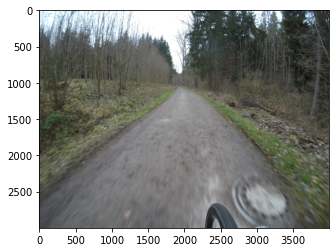

In [6]:
plt.imshow(img)
plt.show()

In [7]:
import torch
import torchvision
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

In [8]:
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

### load training data and calculate image weights for samplers

In [9]:
image_train = torchvision.datasets.ImageFolder(f"{DATA_DIR}/train", transform=torchvision.transforms.ToTensor())

In [10]:
len(image_train)

271

In [11]:
train_ds, val_ds = torch.utils.data.random_split(image_train, [271-30, 30])

In [12]:
image_train.classes

['blurred', 'not_blurred']

##### train

In [13]:
# load value
%store -r train_targets

In [14]:
# this loads every image once to get the targets -- use from store if store has it
if not locals().get("train_targets"):
    train_targets = [target for _, target in train_ds]
    %store train_targets

In [15]:
len(train_targets)

241

In [16]:
counts = np.bincount(train_targets)
counts

array([102, 139])

In [17]:
weight = 1. / counts

In [18]:
weight

array([0.00980392, 0.00719424])

In [19]:
train_samples_weight = torch.tensor([weight[t] for t in train_targets])

Using [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) to fix imbalanced dataset

In [20]:
train_sampler = WeightedRandomSampler(train_samples_weight, len(train_targets), replacement=True)

In [21]:
next(iter(train_sampler))

221

In [22]:
# only to demonstrate, not used below
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=3, sampler=train_sampler)

In [23]:
next(iter(train_dataloader))[1]

tensor([1, 0, 0])

#### validation

In [24]:
val_targets = [target for _, target in val_ds]

In [25]:
counts = np.bincount(val_targets)

In [26]:
counts

array([12, 18])

In [27]:
weight = 1 / counts

In [28]:
val_samples_weight = torch.tensor([weight[t] for t in val_targets])

In [29]:
val_sampler = WeightedRandomSampler(val_samples_weight, len(val_targets), replacement=True)

### test data

In [30]:
## majority agreed test labels
test1_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test1", transform=torchvision.transforms.ToTensor())

In [31]:
## more ambiguous test datasets 
test2_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test2", transform=torchvision.transforms.ToTensor())

In [32]:
test_ds = test1_ds + test2_ds

In [33]:
test_ds[0][1]

0

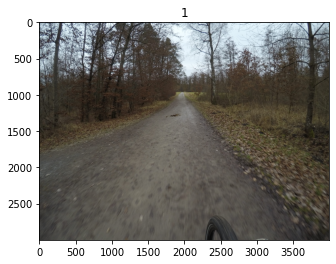

In [34]:
number = 3
plt.imshow(train_ds[number][0].permute(1, 2, 0))
plt.title('%i' % train_ds[number][1])
plt.show()

In [35]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

In [36]:
from torchmetrics import Accuracy
from torch.nn import functional as F

In [37]:
class BlurredModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 2

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            #    3000 chan20 maxpool2  -> 59930020  #  gpu=0; 25min/epoch 😲
            #  1 3000 chan10 maxpool2  -> 29965010
            #  2 3000 chan10 maxpool4  -> 7482510
            #  3 3000 chan10 maxpool3  -> 13306680
            torch.nn.Linear(29965010, 2),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        
        if name == "train":
            self.train_acc(preds, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(preds, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size, sampler=train_sampler)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(val_ds, batch_size=self.batch_size, sampler=val_sampler)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(test_ds, batch_size=self.batch_size)

In [38]:
model = BlurredModel()
model

BlurredModel(
  (model): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=29965010, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [39]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p2--blurred--voted")
wandb_logger.watch(model)
trainer = lightning.Trainer(gpus=1, max_epochs=10, logger=wandb_logger)
trainer.fit(model)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 59.9 M
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
59.9 M    Trainable params
0         Non-trainable params
59.9 M    Total params
239.721   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [40]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part2/workshop-p2--blurred--voted/zi1c729b/checkpoints/epoch=9-step=1209.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part2/workshop-p2--blurred--voted/zi1c729b/checkpoints/epoch=9-step=1209.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.699999988079071, 'test/loss': 2.9432060718536377}
--------------------------------------------------------------------------------


[{'test/loss': 2.9432060718536377, 'test/acc': 0.699999988079071}]

In [41]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
test/acc,▁
test/loss,▁
train/acc,▁▁▁████▁████▁███████████
train/loss,█▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val/acc,▇▃█▁▄▄▅▆▅▃
val/loss,█▂▁▂▃▁▃▁▂▂
epoch,10
test/acc,0.7
test/loss,2.94321


In [42]:
import termcolor

In [43]:
def test_result(idx, image, model):
    img = image[0][None, :]
    r = model(img)
    is_correct = bool(i[1] == torch.argmax(r))
    is_correct = termcolor.colored(is_correct, "green" if is_correct else "red")
    return " ".join([str(i) for i in [idx, image[1], is_correct, torch.argmax(r), r]])

In [44]:
for idx, i in enumerate(test1_ds):
    print(test_result(idx, i, trainer.model))

0 0 False tensor(1) tensor([[-2.6154,  2.6082]], grad_fn=<AddmmBackward0>)
1 0 True tensor(0) tensor([[ 0.0199, -0.0213]], grad_fn=<AddmmBackward0>)
2 0 True tensor(0) tensor([[ 3.5279, -3.5294]], grad_fn=<AddmmBackward0>)
3 1 True tensor(1) tensor([[-32.9954,  32.9941]], grad_fn=<AddmmBackward0>)
4 1 True tensor(1) tensor([[-14.9056,  14.8772]], grad_fn=<AddmmBackward0>)
5 1 True tensor(1) tensor([[-7.9347,  7.9368]], grad_fn=<AddmmBackward0>)
6 1 True tensor(1) tensor([[-18.6055,  18.5901]], grad_fn=<AddmmBackward0>)
7 1 True tensor(1) tensor([[-2.0104,  2.0129]], grad_fn=<AddmmBackward0>)
8 1 True tensor(1) tensor([[-2.6694,  2.6700]], grad_fn=<AddmmBackward0>)
9 1 True tensor(1) tensor([[-3.2093,  3.2132]], grad_fn=<AddmmBackward0>)


In [45]:
for idx, i in enumerate(test2_ds):
    print(test_result(idx, i, trainer.model))

0 0 True tensor(0) tensor([[ 0.5617, -0.5659]], grad_fn=<AddmmBackward0>)
1 0 True tensor(0) tensor([[ 0.8638, -0.8603]], grad_fn=<AddmmBackward0>)
2 0 False tensor(1) tensor([[-9.5698,  9.5807]], grad_fn=<AddmmBackward0>)
3 0 False tensor(1) tensor([[-10.8542,  10.8453]], grad_fn=<AddmmBackward0>)
4 0 True tensor(0) tensor([[ 1.6736, -1.6723]], grad_fn=<AddmmBackward0>)
5 0 False tensor(1) tensor([[-1.0494,  1.0455]], grad_fn=<AddmmBackward0>)
6 0 False tensor(1) tensor([[-2.8959,  2.8797]], grad_fn=<AddmmBackward0>)
7 1 True tensor(1) tensor([[-4.2531,  4.2543]], grad_fn=<AddmmBackward0>)
8 1 True tensor(1) tensor([[-4.2470,  4.2381]], grad_fn=<AddmmBackward0>)
9 1 False tensor(0) tensor([[ 1.5172, -1.5116]], grad_fn=<AddmmBackward0>)


In [46]:
model_children=list(model.children())

In [47]:
layers=[]

In [48]:
for child in model_children:
    for layer in child.children():
        layers.append(layer)
    
layers = layers[0:3]

In [49]:
layers

[Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [50]:
img = next(iter(torch.utils.data.DataLoader(train_ds, batch_size=20)))[0][13]

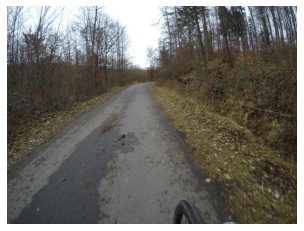

In [51]:
plt.imshow(img.permute(1,2,0).data, cmap='gray')
plt.axis("off")
plt.show()
plt.close()

In [52]:
img = img.unsqueeze(0)
results = [layers[0](img)]

In [53]:
for i in range(1, len(layers)):
    results.append(layers[i](results[-1]))
outputs = results

Layer 1 Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))


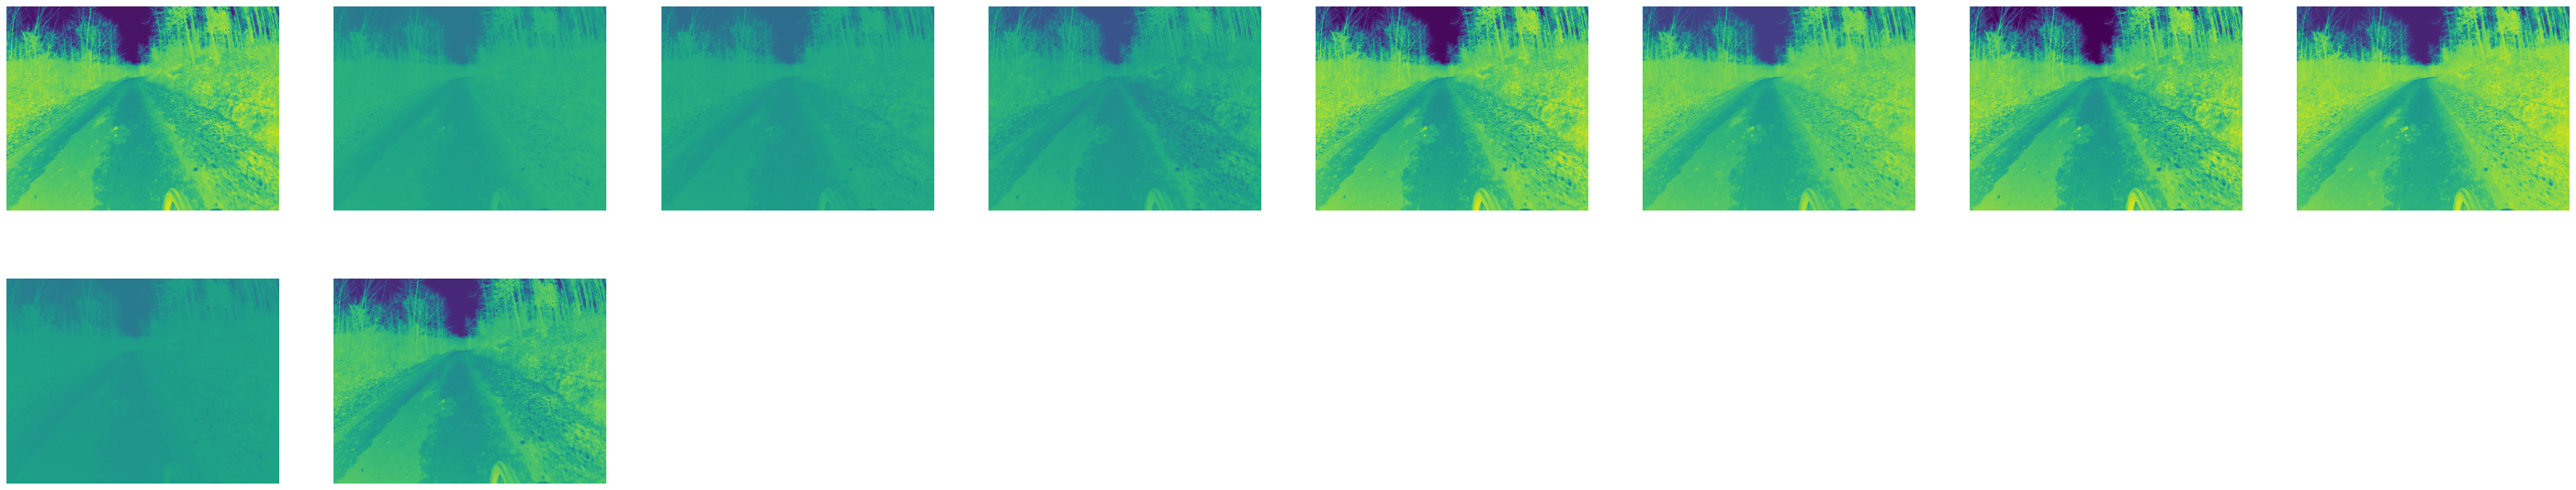

Layer 2 ReLU()


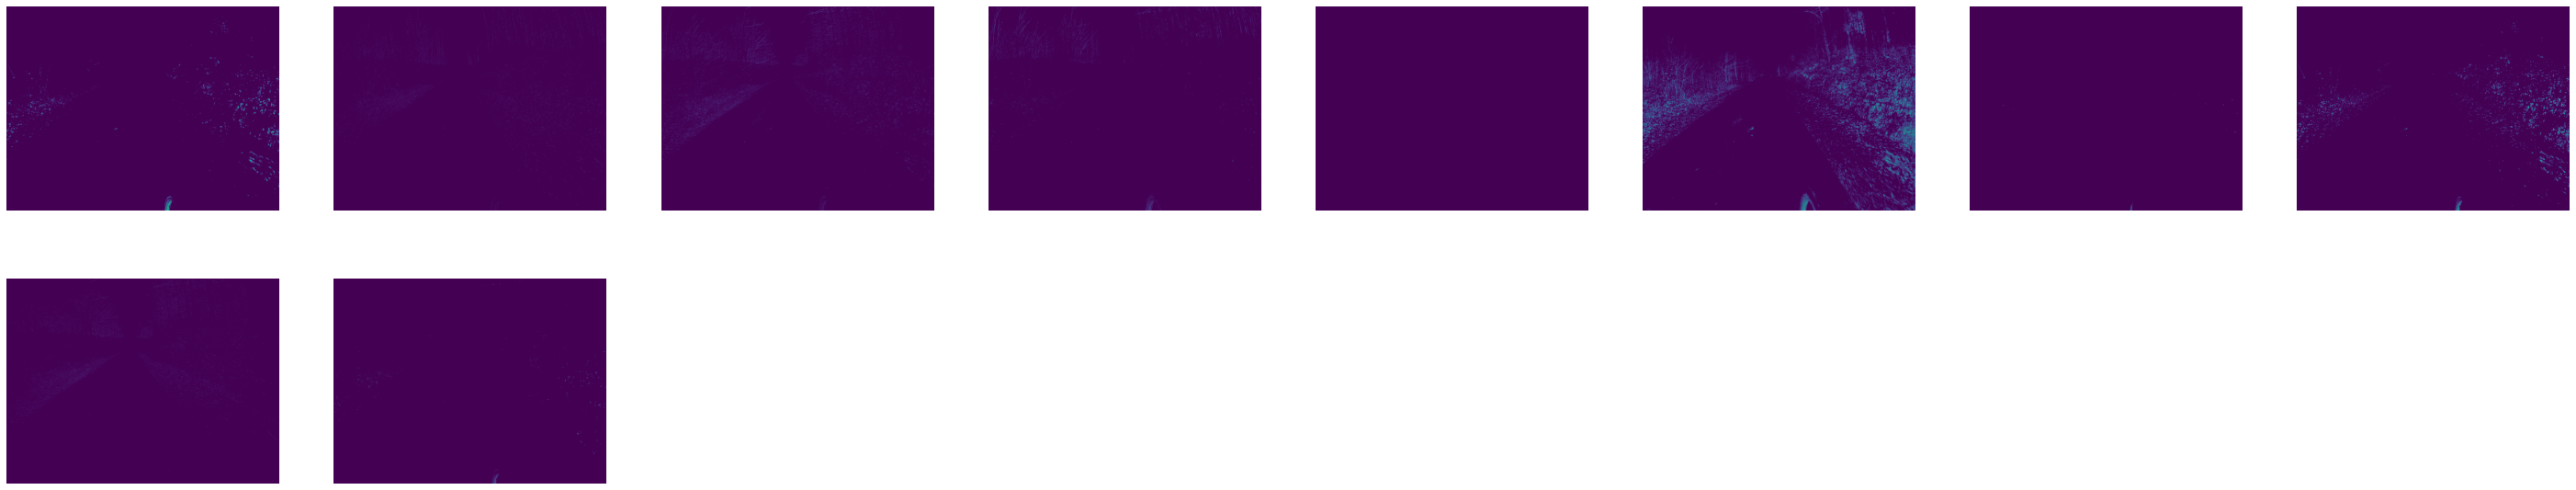

Layer 3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


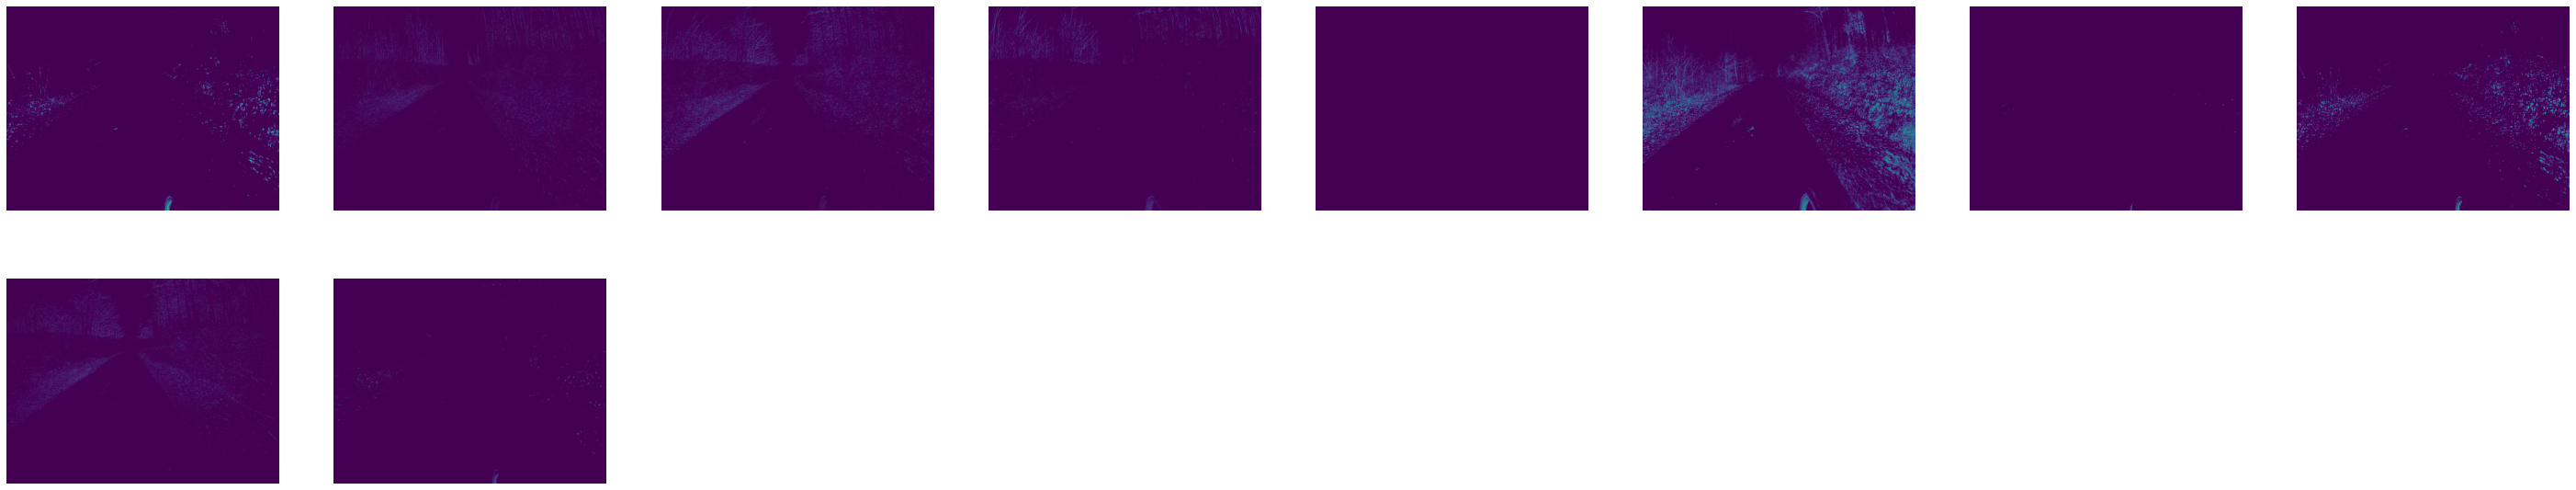

In [54]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer", num_layer + 1, layers[num_layer])
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")
    plt.show()
    plt.close()